# 프로젝트: 뉴스 카테고리 다중분류 : Vocabulary Size를 변경해서 시도해보기
=============================================================================================================

## 목차

>### 1. 데이터 로더 만들기
>### 2. 머신러닝 모델 정의하기
>### 3. 머신러닝 학습 및 결과 확인
>### 4. 딥러닝 모델 정의하기
>### 5. 딥러닝 모델 학습 및 결과 확인
>### 6. 회고
>### 7. Reference
>### 8. 자기다짐 및 아쉬운 점
---

## 루브릭 평가 기준

1. 분류 모델의 accuracy가 기준 이상 높게 나왔는가?
    - 3가지 단어 개수에 대해 8가지 머신러닝 기법을 적용하여 그중 최적의 솔루션을 도출하였다.
2. 분류 모델의 F1 score가 기준 이상 높게 나왔는가?
    - Vocabulary size에 따른 각 머신러닝 모델의 성능변화 추이를 살피고, 해당 머신러닝 알고리즘의 특성에 근거해 원인을 분석하였다.
3. 딥러닝 모델을 활용해 성능이 비교 및 확인되었는가?
    - 동일한 데이터셋과 전처리 조건으로 딥러닝 모델의 성능과 비교하여 결과에 따른 원인을 분석하였다.
---    

## 1. 데이터 로더 만들기

In [32]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Embedding, Dropout, LSTM, Dense, BatchNormalization, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import reuters
import tensorflow_addons as tfa
from tensorflow_addons.metrics import F1Score
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

seed = 42 
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
def data_loader(num_words=None, test_split=0.2):
    
    """
    로이터 뉴스 데이터셋은 0~3까지의 vocabulary가 비어있다.
    사용자와의 약속으로 0은 pad, 1은 sos 토큰, 2는 unk 토큰으로 지정되어있다.
    명시되어있지 않지만 3도 빈칸인것으로 보아 임의로 eos 토큰을 지정하였다.
    """
    
    token_dict = {0:'<pad>', 1:'<sos>', 2:'<unk>', 3:'<eos>'}
    
    (x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=num_words, test_split=test_split)
    
    word_index = reuters.get_word_index(path="reuters_word_index.json")
    index_to_word = {index+3 : word for word, index in word_index.items()}
    word_to_index = {word:index for index, word in index_to_word.items()}

    for index, token in token_dict.items():
        index_to_word[index]=token
    
    x_train = decoder(x_train, index_to_word)
    x_test = decoder(x_test, index_to_word)
    
    return x_train, y_train, x_test, y_test, index_to_word, word_to_index

In [3]:
def decoder(data, index_to_word): # 디코더 함수 -> index 형태에서 word형태로 바꾸어준다.
    decoded = []
    for i in range(len(data)):
        t = ' '.join([index_to_word[index] for index in data[i]])
        decoded.append(t)
        
    return decoded

In [4]:
def total_check(train, test, y_train): # 데이터의 클래스 확인
    fig, axe = plt.subplots(ncols=1)
    fig.set_size_inches(11,5)
    plt.title('class distribution')
    sns.countplot(x = y_train)
    plt.show()
    
    unique_elements, counts_elements = np.unique(y_train, return_counts=True)
    print("각 클래스:", '\n', unique_elements, '\n')
    print('각 클래스별 갯수: ') 
    counts_dict = {}
    for i, v in enumerate(counts_elements):
        counts_dict.update({str(i):v})
    print(counts_dict)

In [5]:
def tfidf_transformer(x_train, x_test): # tfidf 변환 함수
    dtm = CountVectorizer()
    tfidf_transformer = TfidfTransformer()
    
    train_dtm = dtm.fit_transform(x_train)
    tfidf = tfidf_transformer.fit_transform(train_dtm)
    
    test_dtm = dtm.transform(x_test)
    test_tfidf = tfidf_transformer.transform(test_dtm)    
    
    print('Train TF-IDF의 shape: ', tfidf.shape)
    print('Test TF-IDF의 shape: ', test_tfidf.shape)
    print('----'*26)
    
    return tfidf, test_tfidf

In [6]:
x_train_all, y_train_all, x_test_all, y_test_all, idx_to_word, word_to_idx = data_loader(num_words=None)
x_train_5000, y_train_5000, x_test_5000, y_test_5000, idx_to_word, word_to_idx = data_loader(num_words=5000)
x_train_10000, y_train_10000, x_test_10000, y_test_10000, idx_to_word, word_to_idx = data_loader(num_words=10000)
x_train_15000, y_train_15000, x_test_15000, y_test_15000, idx_to_word, word_to_idx = data_loader(num_words=15000)

565248/550378 [==============================] - 0s 0us/step


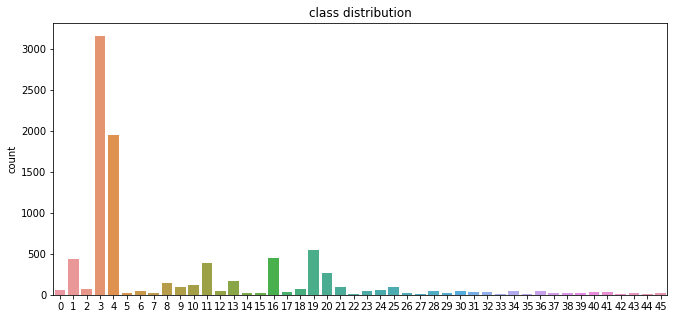

각 클래스: 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45] 

각 클래스별 갯수: 
{'0': 55, '1': 432, '2': 74, '3': 3159, '4': 1949, '5': 17, '6': 48, '7': 16, '8': 139, '9': 101, '10': 124, '11': 390, '12': 49, '13': 172, '14': 26, '15': 20, '16': 444, '17': 39, '18': 66, '19': 549, '20': 269, '21': 100, '22': 15, '23': 41, '24': 62, '25': 92, '26': 24, '27': 15, '28': 48, '29': 19, '30': 45, '31': 39, '32': 32, '33': 11, '34': 50, '35': 10, '36': 49, '37': 19, '38': 19, '39': 24, '40': 36, '41': 30, '42': 13, '43': 21, '44': 12, '45': 18}


In [7]:
total_check(x_train_all, x_test_all, y_train_all)

---
## 2. 머신러닝 모델 정의하기

In [8]:
def nb_class(x_train, x_test, y_train, y_test, num_words): # 나이브 베이즈 분류기
    
    nb_model = MultinomialNB()
    nb_model.fit(x_train, y_train)
    
    predicted = nb_model.predict(x_test)
    acc = round(accuracy_score(y_test, predicted), 4) * 100
    print("단어사전 {} 나이브 베이즈 정확도:".format(num_words), acc)
    print('학습 종료')
    print('----'*26)
    
    return acc, predicted

In [9]:
def cnb_class(x_train, x_test, y_train, y_test, param, num_words): # 컴플리먼트 나이브 베이즈 분류기
    cb = ComplementNB(**param)
    cb.fit(x_train, y_train)
    
    predicted = cb.predict(x_test)
    acc = round(accuracy_score(y_test, predicted), 4) * 100
    print("단어사전 {} 컴플리먼트 나이브 베이즈 정확도: ".format(num_words), acc)
    print('학습 종료')
    print('----'*26)
    
    return acc, predicted

In [10]:
def lr_class(x_train, x_test, y_train, y_test, param, num_words): # 로지스틱 회귀 모델
    lr = LogisticRegression(**param)
    lr.fit(x_train, y_train)
    predicted = lr.predict(x_test) #테스트 데이터에 대한 예측
    acc = round(accuracy_score(y_test, predicted), 4) * 100
    print("단어사전 {} 로지스틱 회귀 정확도: ".format(num_words), acc)
    print('학습 종료')    
    print('----'*26)
    
    return acc, predicted

In [11]:
def spm_class(x_train, x_test, y_train, y_test, param, num_words): # 서포트 벡터 머신
    lsvc = LinearSVC(**param)
    lsvc.fit(x_train, y_train)
    predicted = lsvc.predict(x_test) #테스트 데이터에 대한 예측
    acc = round(accuracy_score(y_test, predicted), 4) * 100
    print("단어사전 {} 서포트 벡터 머신 정확도: ".format(num_words), acc)
    print('학습 종료')    
    print('----'*26)
    
    return acc, predicted

In [12]:
def dt_class(x_train, x_test, y_train, y_test, param, num_words): # 의사결정나무 모델
    tree = DecisionTreeClassifier(**param)
    tree.fit(x_train, y_train)
    predicted = tree.predict(x_test) #테스트 데이터에 대한 예측
    acc = round(accuracy_score(y_test, predicted), 4) * 100
    print("단어사전 {} 의사결정나무 정확도: ".format(num_words), acc)
    print('학습 종료')    
    print('----'*26)
    
    return acc, predicted

In [13]:
def rf_class(x_train, x_test, y_train, y_test, param, num_words): # 랜덤포레스트 모델
    forest = RandomForestClassifier(**param)
    forest.fit(x_train, y_train)
    predicted = forest.predict(x_test) #테스트 데이터에 대한 예측
    acc = round(accuracy_score(y_test, predicted), 4) * 100
    print("단어사전 {} 랜덤 포레스트 정확도: ".format(num_words), acc)
    print('학습 종료')    
    print('----'*26)
    
    return acc, predicted

In [14]:
def gb_class(x_train, x_test, y_train, y_test, param, num_words): # 그래디언트부스팅 모델
    grbt = GradientBoostingClassifier(**param)
    grbt.fit(x_train, y_train)
    predicted = grbt.predict(x_test) #테스트 데이터에 대한 예측
    acc = round(accuracy_score(y_test, predicted), 4) * 100
    print("단어사전 {} 그래디언트 부스팅 트리 정확도: ".format(num_words), acc)
    print('학습 종료')    
    print('----'*26)
    
    return acc, predicted    

In [15]:
def vt_class(x_train, x_test, y_train, y_test,  # 보팅 클래스 모델
             class_name, model_name,
             voting_type = 'soft',
             num_words = 0):
    
    voting_classifier = VotingClassifier(estimators=[
         (class_name[0], model_name[0]),
        (class_name[1], model_name[1]),
        (class_name[2], model_name[2])], 
        voting = voting_type,
        verbose=1)
    
    voting_classifier.fit(x_train, y_train)
    predicted = voting_classifier.predict(x_test) #테스트 데이터에 대한 예측
    acc = round(accuracy_score(y_test, predicted), 4) * 100
    print('\n')
    print("단어사전 {} 클래스 {} , {}, {} 보팅 정확도: ".format(num_words, class_name[0], class_name[1], class_name[2])
          , acc)
    print('학습 종료')    
    print('----'*26)
    
    return acc, predicted

In [16]:
def df_result(acc_list, name_list, name='0'):
    """
    결과값의 Accuracy를 기준으로 
    모든 평가지표의 합으로 성능을 평가할 것이므로 
    DataFrame 형태로 만들어주어 Sum 컬럼을 추가하였음.
    """
    for i in range(len(acc_list)):
        if i == 0:
            acc = pd.Series(acc_list[i], index=[name_list[i]])
            df = pd.DataFrame(acc)
        elif i != 0:
            other = pd.Series(acc_list[i], index=[name_list[i]])
            df = pd.concat([df, other], axis = 0)
    x = df[0].sum()
    x = pd.Series(x, index = ['Sum'])
    df = round(pd.concat([df, x], axis = 0) , 2)
    df.rename(columns = {0: 'Accuracy_{}'.format(name)}, inplace = True)

    return df

In [17]:
def f1_report(pred_list, y_test, model_name_list, name='0'):
    """
    'weighted':
     각 레이블이 불균형해도, weight를 주어 평가지표를 계산한다. 
     precision과 recall의 합이 아닌 F-score를 야기할 수 있다.
     
     이 때문에 classfication_report 중 weighted의 f1_score를 채택하여 사용
    """
    for i in range(len(pred_list)):
        if i == 0:
            x = classification_report(pred_list[i], y_test, output_dict=True)
            x = round(x['weighted avg']['f1-score'], 2)
            x = pd.Series(x, index=[model_name_list[i]])
            x = pd.DataFrame(x)
        elif i != 0:
            y = classification_report(pred_list[i], y_test, output_dict=True)
            y = round(y['weighted avg']['f1-score'], 2)
            y = pd.Series(y, index=[model_name_list[i]])
            x = pd.concat([x, y], axis=0)
    suma = x[0].sum()
    suma = pd.Series(suma, index = ['Sum'])
    x = round(pd.concat([x, suma], axis = 0) , 2)
    x.rename(columns = {0: 'F1-score_{}'.format(name)}, inplace=True)
    
    return x

- `'weighted': 각 레이블이 불균형해도, weight를 주어 평가지표를 계산한다. precision과 recall의 합이 아닌 F-score를 야기할 수 있다.`
    - 위 데이터에서 확인했듯 클래스는 46개이지만 3,4번 클래스에 가장 많은 데이터가 몰려있음으로 불균형이 확연하게 눈에 띈다. 때문에 위의 평가 지표를 선택하였다.

In [18]:
def concat_df(df1, df2, df3, df4):
    x = pd.concat([df1, df2, df3, df4], axis=1)
    
    return x

---
## 3. 머신러닝 모델 학습 및 결과 확인

In [19]:
# 하이퍼 파라미터
# 하이퍼 파라미터는 LMS와 동일하게 변경하지 않았음.

param = {'spm_param' : {'C':1000, 'penalty':'l1', 'max_iter': 3000, 'dual':False, 'verbose':0, 'random_state':seed},
         'lr_param' : {'C':10000, 'penalty':'l2', 'max_iter':3000, 'n_jobs': -1, 'verbose':0, 'random_state': seed},
         'dt_param' : {'max_depth':10, 'random_state': seed},
         'rf_param' : {'n_estimators':5, 'random_state':seed, 'verbose':0, 'n_jobs': -1},
         'gb_param' : {'random_state':seed, 'verbose': 0},
         'cnb_param' : {'norm': False}}
                      
class_name = ['lr', 'CNB', 'grbt'] # 보팅에 들어갈 3가지 모델
model_name = [LogisticRegression(**param['lr_param']), 
              ComplementNB(**param['cnb_param']), 
              GradientBoostingClassifier(**param['gb_param'])] # 보팅에 사용할 3가지 모델의 이름
param_name = ['lr_param', 'cnb_param', 'gb_param'] # 파라미터 이름

model_name_list = ['Naive bayes', 'Complement Naive bayes', 'Logistic Regression', 'Support Vector Machine', 
                 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'Voting']

In [20]:
def total_learning(x_train, x_test, y_train, y_test, class_name, model_name, param_name, param, num_words = None):
    
    """
    함수 내에서 TF-IDF로 변형하여 
    나이브 베이즈, 컴프리먼트 나이브 베이즈, 로지스틱 회귀,
    서포트 벡터 머신, 의사결정나무, 랜덤포레스트,
    그래디언트 부스팅, 보팅 클래스의 머신러닝 결과를 확인할 수 있음.
    """
    
    tfidf, test_tfidf = tfidf_transformer(x_train, x_test)
    
    nb_acc, nb_pred = nb_class(tfidf, test_tfidf, y_train, y_test, num_words)   
    cnb_acc, cnb_pred = cnb_class(tfidf, test_tfidf, y_train, y_test, 
                         param['cnb_param'], num_words)
    lr_acc, lr_pred = lr_class(tfidf, test_tfidf, y_train, y_test, 
                       param['lr_param'], num_words)
    spm_acc, spm_pred = spm_class(tfidf, test_tfidf, y_train, y_test, 
                         param['spm_param'], num_words)
    dt_acc, dt_pred = dt_class(tfidf, test_tfidf, y_train, y_test, 
                       param['dt_param'], num_words)
    rf_acc, rf_pred = rf_class(tfidf, test_tfidf, y_train, y_test, 
                       param['rf_param'], num_words)
    gb_acc, gb_pred = gb_class(tfidf, test_tfidf, y_train, y_test, 
                       param['gb_param'], num_words)
    vt_acc, vt_pred = vt_class(tfidf, test_tfidf, y_train, y_test, 
                       class_name, model_name, num_words = num_words)        
    
    print('===='*26)
    
    """
    결과값으로 각 모델들의 예측값을 리턴
    """
    
    return [nb_pred, cnb_pred, lr_pred, spm_pred, dt_pred, rf_pred, gb_pred, vt_pred], [nb_acc, cnb_acc, lr_acc, spm_acc, dt_acc, rf_acc, gb_acc, vt_acc]

In [21]:
pred_list_all, acc_list_all = total_learning(x_train_all, x_test_all, y_train_all, y_test_all, class_name, model_name, param_name, param, num_words = None)
pred_list_5000, acc_list_5000 = total_learning(x_train_5000, x_test_5000, y_train_5000, y_test_5000, class_name, model_name, param_name, param, num_words = 5000)
pred_list_10000, acc_list_10000 = total_learning(x_train_10000, x_test_10000, y_train_10000, y_test_10000, class_name, model_name, param_name, param, num_words = 10000)
pred_list_15000, acc_list_15000 = total_learning(x_train_15000, x_test_15000, y_train_15000, y_test_15000, class_name, model_name, param_name, param, num_words = 15000)

Train TF-IDF의 shape:  (8982, 26506)
Test TF-IDF의 shape:  (2246, 26506)
--------------------------------------------------------------------------------------------------------
단어사전 None 나이브 베이즈 정확도: 59.97
학습 종료
--------------------------------------------------------------------------------------------------------
단어사전 None 컴플리먼트 나이브 베이즈 정확도:  76.49000000000001
학습 종료
--------------------------------------------------------------------------------------------------------
단어사전 None 로지스틱 회귀 정확도:  81.61
학습 종료
--------------------------------------------------------------------------------------------------------
단어사전 None 서포트 벡터 머신 정확도:  79.07
학습 종료
--------------------------------------------------------------------------------------------------------
단어사전 None 의사결정나무 정확도:  62.019999999999996
학습 종료
--------------------------------------------------------------------------------------------------------
단어사전 None 랜덤 포레스트 정확도:  65.23
학습 종료
----------------------------------------------------

In [52]:
df1 = df_result(acc_list_5000, model_name_list, name='5000')
df2 = df_result(acc_list_10000, model_name_list, name='10000')
df3 = df_result(acc_list_15000, model_name_list, name='15000')
df4 = df_result(acc_list_all, model_name_list, name='All')
f1 = f1_report(pred_list_5000, y_test_5000, model_name_list, name='5000')
f2 = f1_report(pred_list_10000, y_test_10000, model_name_list, name='10000')
f3 = f1_report(pred_list_15000, y_test_15000, model_name_list, name='15000')
f4 = f1_report(pred_list_all, y_test_all, model_name_list, name='All')

acc_df = concat_df(df1, df2, df3, df4)
f1_df = concat_df(f1, f2, f3, f4)

acc_df

,Accuracy_5000,Accuracy_10000,Accuracy_15000,Accuracy_All
Naive bayes,67.32,65.67,63.31,59.97
Complement Naive bayes,77.07,77.07,77.20,76.49
Logistic Regression,80.32,81.03,81.52,81.61
Support Vector Machine,76.89,78.18,78.94,79.07
Decision Tree,61.98,62.20,61.84,62.02
Random Forest,69.32,67.76,67.41,65.23
Gradient Boosting,76.85,77.07,76.63,76.94
Voting,81.43,81.43,81.17,81.75
Sum,591.18,590.41,588.02,583.08


In [23]:
f1_df

,F1-score_5000,F1-score_10000,F1-score_15000,F1-score_All
Naive bayes,0.75,0.74,0.72,0.69
Complement Naive bayes,0.80,0.80,0.80,0.80
Logistic Regression,0.81,0.82,0.82,0.82
Support Vector Machine,0.77,0.79,0.79,0.79
Decision Tree,0.67,0.67,0.66,0.66
Random Forest,0.72,0.71,0.70,0.68
Gradient Boosting,0.77,0.77,0.77,0.77
Voting,0.82,0.82,0.81,0.82
Sum,6.11,6.12,6.07,6.03


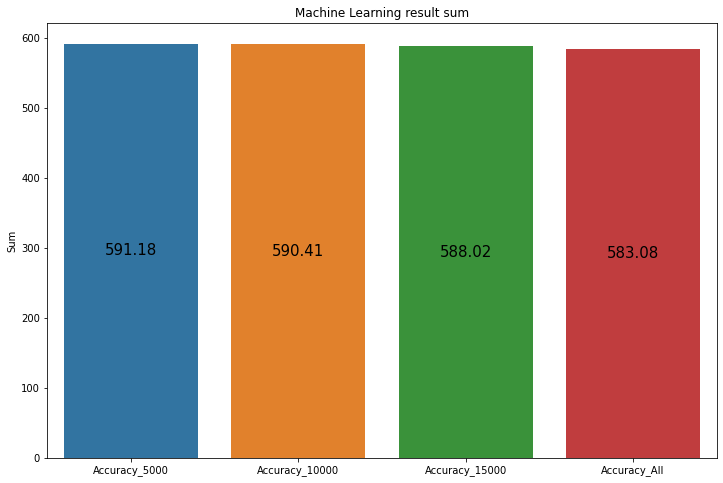

In [24]:
acc_df_T = acc_df.T

plt.figure(figsize=(12,8))
ax = sns.barplot(data=acc_df_T, x=acc_df_T.index, y= 'Sum')

containers = ax.containers[0]
ax.bar_label(containers, labels=[f'{x:,.2f}' for x in containers.datavalues], label_type='center', fontsize=15)
plt.title('Machine Learning result sum')

plt.show()

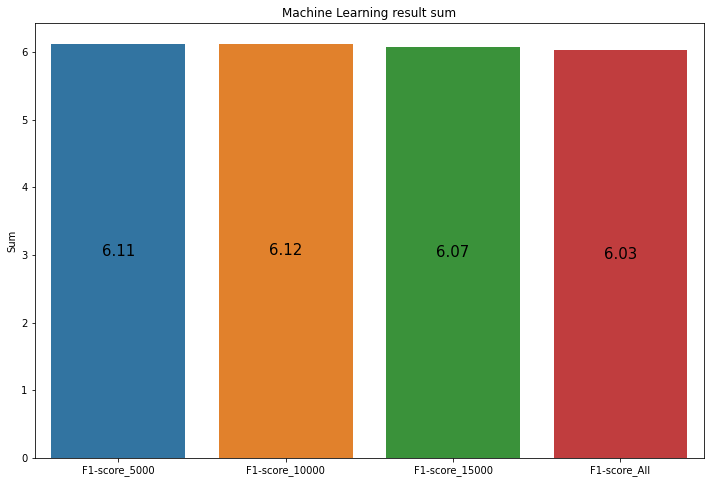

In [25]:
f1_df_T = f1_df.T

plt.figure(figsize=(12,8))
ax = sns.barplot(data=f1_df_T, x=f1_df_T.index, y= 'Sum')

containers = ax.containers[0]
ax.bar_label(containers, labels=[f'{x:,.2f}' for x in containers.datavalues], label_type='center', fontsize=15)
plt.title('Machine Learning result sum')

plt.show()

- 위 결과에서 보듯 `num_words = 5000` 이 가장 좋은 성능을 보였다고 판단 가능할듯 하여 아래 딥러닝에서도 채택하여 같은 vocab_size로 비교해보겠음.

---
## 4. 딥러닝 모델 정의하기

In [26]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=5000, test_split=0.2)

In [27]:
x_train = pad_sequences(x_train, padding='post')
x_test = pad_sequences(x_test, padding='post')

In [28]:
x_train, x_val, y_train, y_val = train_test_split(x_train,
                                                  y_train, 
                                                  random_state = seed,
                                                  test_size=0.2)

In [29]:
print(' 훈련 데이터셋의 길이: ',len(x_train),'\n', '벨리데이션 데이터셋의 길이: ', len(x_val))
print('----'*32)
print(' 훈련 라벨데이터셋의 길이: ', len(y_train), '\n', '벨리데이션 라벨데이터셋의 길이: ', len(y_val))
print('----'*32)

 훈련 데이터셋의 길이:  7185 
 벨리데이션 데이터셋의 길이:  1797
--------------------------------------------------------------------------------------------------------------------------------
 훈련 라벨데이터셋의 길이:  7185 
 벨리데이션 라벨데이터셋의 길이:  1797
--------------------------------------------------------------------------------------------------------------------------------


---
## 5. 딥러닝 모델 학습 및 결과 확인

In [33]:
# 하이퍼 파라미터
vocab_size = 5000
embedding_size = 128
batch_size = 16
units = 64
epochs = 100
drop_rate = 0.5

# optimizer
learning_rate = 0.001
optim_adam = Adam(learning_rate = learning_rate)

# metrics
num_classes = 46
from_logits = False
average = 'weighted'

losses_scc = SparseCategoricalCrossentropy(from_logits = from_logits)
f1_score = F1Score(num_classes = num_classes, average = average)

In [34]:
class model(keras.Model):
    def __init__(self, vocab_size, embedding_size, units, drop_rate):
        super().__init__()
        self.Embedding = Embedding(vocab_size, embedding_size, mask_zero=True)
        self.lstm1 = Bidirectional(LSTM(units, return_sequences = True, activation='tanh', dropout=drop_rate))
        self.batch1 = BatchNormalization()
        self.drop1 = Dropout(drop_rate)
        self.lstm2 = Bidirectional(LSTM(units*2, activation='tanh', dropout=drop_rate))
        self.batch2 = BatchNormalization()
        self.drop2 = Dropout(drop_rate)            
        self.dense = Dense(46, activation='softmax')
        
    def call(self, x):
        x = self.Embedding(x)
        x = self.lstm1(x)
        x = self.batch1(x)
        x = self.drop1(x)
        x = self.lstm2(x)
        x = self.batch2(x)
        x = self.drop2(x)       
        x = self.dense(x)
        
        return x

In [35]:
model = model(vocab_size, embedding_size, units, drop_rate)

model.compile(optimizer=optim_adam,
              loss=losses_scc,
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

history = model.fit(x_train, y_train, batch_size=batch_size,
                    verbose='auto', epochs=epochs,
                    validation_data=(x_val, y_val), callbacks=[es])

Epoch 1/100
450/450 [==============================] - 56s 93ms/step - loss: 2.2519 - accuracy: 0.5478 - val_loss: 1.3960 - val_accuracy: 0.6934
Epoch 2/100
450/450 [==============================] - 38s 84ms/step - loss: 1.3729 - accuracy: 0.7070 - val_loss: 1.1301 - val_accuracy: 0.7490
Epoch 3/100
450/450 [==============================] - 38s 85ms/step - loss: 1.0661 - accuracy: 0.7594 - val_loss: 1.2688 - val_accuracy: 0.7501
Epoch 4/100
450/450 [==============================] - 38s 83ms/step - loss: 0.8962 - accuracy: 0.7955 - val_loss: 1.0434 - val_accuracy: 0.7769
Epoch 5/100
450/450 [==============================] - 38s 83ms/step - loss: 0.7287 - accuracy: 0.8284 - val_loss: 1.0538 - val_accuracy: 0.7969
Epoch 6/100
450/450 [==============================] - 37s 83ms/step - loss: 0.6376 - accuracy: 0.8502 - val_loss: 1.1182 - val_accuracy: 0.7885
Epoch 7/100
450/450 [==============================] - 37s 83ms/step - loss: 0.5889 - accuracy: 0.8571 - val_loss: 1.3187 - val_ac

In [36]:
test_acc = model.evaluate(x_test, y_test, verbose=2)

71/71 - 6s - loss: 1.1190 - accuracy: 0.7996


- 약 80% 정도의 정확도를 보여준다.

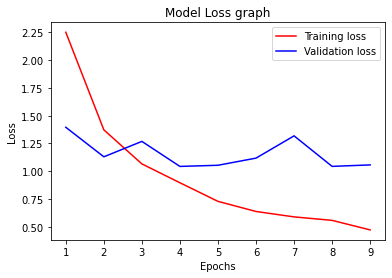

In [37]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epoch = range(1, len( acc) + 1)

plt.plot(epoch, loss, 'r', label='Training loss')
plt.plot(epoch, val_loss, 'b', label='Validation loss')
plt.title('Model Loss graph')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

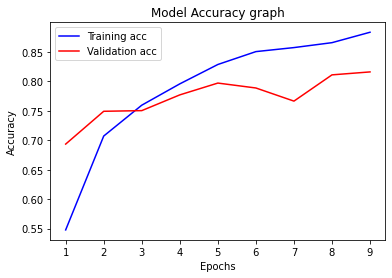

In [38]:
plt.plot(epoch, acc, 'b', label='Training acc')
plt.plot(epoch, val_acc, 'r', label='Validation acc')
plt.title('Model Accuracy graph')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

- 어느정도 overfitting 문제가 존재하나 치우친 데이터셋의 한계인 것으로 보임.

In [44]:
def deep_f1_df(model, x_test, y_test):
    y_test = to_categorical(y_test)
    y_pred = model.predict(x_test)
    f1 = F1Score(num_classes=46, average='weighted')
    f1.update_state(y_test, y_pred)
    f1 = f1.result()
    f1 = f1.numpy()
    
    f1 = pd.Series(f1, index=['F1 Score'])
    f1 = pd.DataFrame(f1)
    
    return f1

In [45]:
def acc_df(acc, name='Accuracy'):
    x = acc[-1]
    x = pd.Series(x, index=[name])
    x = pd.DataFrame(x)
    
    return x

In [46]:
deep_f1_df = deep_f1_df(model, x_test, y_test)
df_acc = acc_df(acc)
df_val = acc_df(val_acc, 'Val Accuracy')
df_test = acc_df(test_acc, 'Test Accuracy')

fin_df = pd.concat([deep_f1_df, df_acc, df_val, df_test], axis=0)
fin_df.rename(columns={0: 'model_5000'}, inplace = True)

In [53]:
acc_df # 머신러닝 Accuracy 데이터 프레임

,Accuracy_5000,Accuracy_10000,Accuracy_15000,Accuracy_All
Naive bayes,67.32,65.67,63.31,59.97
Complement Naive bayes,77.07,77.07,77.20,76.49
Logistic Regression,80.32,81.03,81.52,81.61
Support Vector Machine,76.89,78.18,78.94,79.07
Decision Tree,61.98,62.20,61.84,62.02
Random Forest,69.32,67.76,67.41,65.23
Gradient Boosting,76.85,77.07,76.63,76.94
Voting,81.43,81.43,81.17,81.75
Sum,591.18,590.41,588.02,583.08


In [50]:
f1_df # 머신러닝 F1_score 데이터 프레임

,F1-score_5000,F1-score_10000,F1-score_15000,F1-score_All
Naive bayes,0.75,0.74,0.72,0.69
Complement Naive bayes,0.80,0.80,0.80,0.80
Logistic Regression,0.81,0.82,0.82,0.82
Support Vector Machine,0.77,0.79,0.79,0.79
Decision Tree,0.67,0.67,0.66,0.66
Random Forest,0.72,0.71,0.70,0.68
Gradient Boosting,0.77,0.77,0.77,0.77
Voting,0.82,0.82,0.81,0.82
Sum,6.11,6.12,6.07,6.03


In [51]:
fin_df # 딥러닝 데이터프레임

,model_5000
F1 Score,0.791774
Accuracy,0.883090
Val Accuracy,0.815804
Test Accuracy,0.799644


- 딥러닝 데이터와 머신러닝 데이터가 거의 비슷한 value 값을 보여주나 머신러닝에서 조금 더 우세한듯 보인다.

---
## 6. 회고

### 이번 프로젝트를 하면서 어려웠던 점
>- 이번 프로젝트는 생각보다 어려웠습니다. 오랜만에 사용해보는 머신러닝 기법이기에 사용법에 어려움을 겪었고 특히나 각 모델, 평가지표 들의 논리 이해가 쉽지 않았습니다. 그래도 예전 머신러닝때보다 더욱 발전한 실력으로 함수도 짜보고 코드를 짜보니 재밌던 부분도 있었습니다.
### 이번 프로젝트에서 학습한 내용
>- 예전엔 몰랐던 모델들의 파라미터들에 대해 더욱 자세히 알게되었습니다. 이제는 각 파라미터의 의미도 어느정도 눈에 들어오고 다시 한번 머신러닝을 하게 된다면 이번보다 더욱 좋은 성능을 이끌어낼 수 있을 것 같습니다.
>- 또한 처음으로 모델 정의 과정에서 언패킹을 처음 써보았는데 잘 되지않아 어렵다가도 성공하게되니 상당히 재밌는 부분으로 다가왔습니다.
### 알아낸 점이나 모호한점
>- 여전히 평가지표나 모델들에 대해 많이 알아보았지만 여전히 모호한 점들이 많습니다. 각 파라미터들의 정확한 의미, 평가지표의 수식 이해 등 모호한 부분들이 꽤나 있습니다.
### 루브릭 평가지표를 맞추기 위해 노력했던 점
>- __1. 3가지 단어 개수에 대해 8가지 머신러닝 기법을 적용하여 그중 최적의 솔루션을 도출하였다.__ 에 대해서는 위에서 사용했듯 `num_words = 5000` 이 Accuracy 측면에서 가장 좋았으며 f1-score 도 함께 고려했을 때 역시 다른 num_words 들과 비교했을 때 종합적으로 좋았습니다.
>- __2. Vocabulary size에 따른 각 머신러닝 모델의 성능변화 추이를 살피고, 해당 머신러닝 알고리즘의 특성에 근거해 원인을 분석하였다.__ 머신러닝 알고리즘의 특성에 근거해 원인 분석까지는 어려웠지만 각 머신러닝 모델의 성능변화 추이는 데이터프레임 형태로 살폈으며 그를 근거로 최적의 Vocabulary size를 채택하였습니다.
>- __3. 동일한 데이터셋과 전처리 조건으로 딥러닝 모델의 성능과 비교하여 결과에 따른 원인을 분석하였다.__ 에 관해서는 동일한 데이터셋과 전처리 조건으로 데이터를 사용하였으며 결과적으로는 클래스가 과하게 치우친 데이터셋의 문제인것으로 판단되었으며 그 결과를 감안하더라도 괜찮은 Accuracy를 보여주었습니다.
### 루브릭 평가지표를 달성하지 못했다면 이유
>- 아무래도 2,3번 루브릭이 애매합니다. 해당 머신러닝 알고리즘의 특성에 근거.. 하였다는 부분은 상당히 애매하며 3번 루브릭에서 또한 결과에 따른 원인을 분석하였는가 에 대한것이 조금 애매하기에 아마 달성하지 못했다면 위의 이유때문이지 않을까 싶습니다.

---
## 7. Reference

- [사이킷런 공식문서](https://scikit-learn.org/stable/search.html?q=fit)
- [서포트 벡터 머신 파라미터 공식문서](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html?highlight=svc#sklearn.svm.LinearSVC)
- [로지스틱 회귀 파라미터 공식문서](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?highlight=logisticregression#sklearn.linear_model.LogisticRegression)
- [의사결정나무 파라미터 공식문서](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html?highlight=decisiontree#sklearn.tree.DecisionTreeClassifier)
- [랜덤포레스트 파라미터 공식문서](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=randomforest#sklearn.ensemble.RandomForestClassifier.fit)
- [그래디언트 부스팅 파라미터 공식문서](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html?highlight=gradientboostingclassifier#sklearn.ensemble.GradientBoostingClassifier)
- [컴프리먼트 나이브 베이즈 파라미터 공식문서](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.ComplementNB.html?highlight=complementnb#sklearn.naive_bayes.ComplementNB)
- [보팅 파라미터 공식문서](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html?highlight=votingclass#sklearn.ensemble.VotingClassifier)
- [F1-Score 참고 블로그](https://aimb.tistory.com/152)

---
## 8. 자기다짐 및 아쉬운 점

- 이번 프로젝트에서는 루브릭 평가지표에 대해서 정확한 의도를 파악하지 못해 제대로 했는지에 대한 아쉬움이 있습니다. 또한 머신러닝이라는 주제가 과연 우리가 이후에 더 사용하게 될까? 라는 의문이 들어 더욱 자세히 알아보지 못하기도 하였기에 예전보다 조금 더 나태해지지 않았나.. 하는 생각이 듭니다.
  
  
- 앞으로 더욱 어려워질텐데 나태해지지 말고 더욱 정진해야겠다고 생각하게된 프로젝트였습니다.